#Titanic - Kaggle Training

In [60]:
import numpy as np
import pandas as pd
import csv as csv

import os
from time import time
import operator

from Tools.tools import *

from sklearn.tree import *
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
import sklearn.svm as svm
from sklearn.preprocessing import *
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV    

import matplotlib.pyplot as plt
%matplotlib inline 
%qtconsole

In [2]:
# Multiprocessing
os.system('taskset -p 0xffffffff %d' % os.getpid())

1

##Preprocessing

In [78]:
train = pd.read_csv("M:/datasciences/Projets/Kaggle/Titanic/train.csv")
test = pd.read_csv("M:/datasciences/Projets/Kaggle/Titanic/test.csv")

## NA imputation
feature_columns_to_use = ['Pclass', 'Sex', 'Age', 'Fare', 'Parch', 'Embarked', 'SibSp']
big_X = train[feature_columns_to_use].append(test[feature_columns_to_use])
big_X_imputed = DataFrameImputer().fit_transform(big_X)

# Let's rebuild train & test datasets with imputed values
train_X = big_X_imputed[:train.shape[0]]
test_X = big_X_imputed[train.shape[0]:]

# Male = 1 / Female = 0  using map function
train_X['Gender'] = train_X['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
test_X['Gender'] = test_X['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
train_X = train_X.drop(['Sex'], axis=1)
test_X = test_X.drop(['Sex'], axis=1)

## Dummies
##Embarked split
train_X = feature_to_dummy(train_X, 'Embarked')
test_X = feature_to_dummy(test_X, 'Embarked')

#Pclass
train_X = feature_to_dummy(train_X, 'Pclass')
test_X = feature_to_dummy(test_X, 'Pclass')

train_Y = train['Survived']

C:\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Features selection

In [74]:
#with linear SVC **Gridsearched**
lin_svc = LinearSVC(C=100)
lin_svc.fit_transform(train_X, train_Y)

#with rf **Gridsearched**
rf = RandomForestClassifier(n_estimators=100, max_features=1, criterion='entropy') 
rf.fit_transform(train_X, train_Y)

#with logitCV **NOT DONE YET!**
logitcv = lm.LogisticRegressionCV()
logitcv.fit_transform(train_X, train_Y)

array([[ 1.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  1.],
       [ 1.,  1.,  0.],
       [ 1.,  0.,  1.]])

##Models

###Random Forests

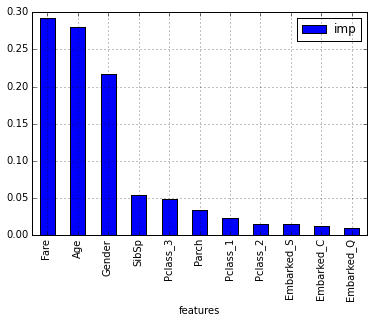

In [75]:
model_rf = RandomForestClassifier(n_estimators = 10,
                                  max_depth = None,
                                  bootstrap = True,
                                  criterion = "entropy")

#features importance
imp_list = list(zip(train_X.columns, np.transpose(forest.feature_importances_)))
imp_list.sort(key=operator.itemgetter(1), reverse=True)
imp_rf = pd.DataFrame(imp_list, columns=['features', 'imp'])
imp_rf.plot(kind='bar', x='features')

Let's keep the 3 first features.
####The next line can be change if we decide to keep more variable :

In [76]:
train_X_imp = rf.fit_transform(train_X, train_Y)

In [ ]:
#combining the feature with pipeline.FeatureUnion => use it in the grid
combined_features = FeatureUnion([("rf_select", rf), ("rf_est", model_rf)])
# Use combined features to transform dataset: 
X_features = combined_features.fit(train_X, train_Y).transform(train_X)
#TODO : modifier la FeatureUnion qui ne sert à rien ici.


###SVC

In [53]:
##SVC-lin
model_svc = svm.SVC(kernel='linear')
res_svc = model_svc.fit(train_X, train_Y) 

###Logistic

In [ ]:
## Logistic
model_logit = lm.LogisticRegression()
res_logit = model_logit.fit(train_X, train_Y)
#coef
pd.DataFrame(list(zip(train_X.columns, np.transpose(res_logit.coef_))))

##Find the best parameters (Gridsearch)

###parameters

In [24]:
param_grid_rf = {"n_estimators" : [10, 20, 30, 50, 100],
              "max_depth": [3, None],
              "max_features": [1, 3, 5],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
              
param_grid_svc = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

param_grid_GBR = {
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 9, 15, 30, 50, 100],
              'n_estimators': [1000, 2000, 3000],
              }

param_grid_ada = {
            'n_estimators': [15,20,25,30,35,40,45],
            'learning_rate': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            'max_features': [1, 3, 5, 6]
            'max_depth': [
            }

param_ExtraTrees = {
            'n_estimators': [100,200,300,400,500,600,700,1000]
            'max_depth': [1, 2, 5, 7, 10],
            'min_samples_leaf': [1, 2 , 5, 7, 10],
            'min_samples_split': [1, 2 , 5, 7, 10]
            }

###gridsearch

In [77]:
model_rf = RandomForestClassifier()
grid_search = GridSearchCV(model_rf, param_grid=param_grid_rf, n_jobs=6)
start = time()
grid_search.fit(train_X, train_Y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report_grid(grid_search.grid_scores_)

GridSearchCV took 43.96 seconds for 1080 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.835 (std: 0.023)
Parameters: {'criterion': 'entropy', 'min_samples_leaf': 3, 'max_features': 3, 'bootstrap': True, 'n_estimators': 50, 'min_samples_split': 10, 'max_depth': None}

Model with rank: 2
Mean validation score: 0.833 (std: 0.017)
Parameters: {'criterion': 'entropy', 'min_samples_leaf': 3, 'max_features': 5, 'bootstrap': True, 'max_depth': None, 'min_samples_split': 1, 'n_estimators': 20}

Model with rank: 3
Mean validation score: 0.832 (std: 0.022)
Parameters: {'criterion': 'entropy', 'min_samples_leaf': 1, 'max_features': 3, 'bootstrap': True, 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}



In [80]:
grid_search = GridSearchCV(model_svc, param_grid=param_grid_svc, n_jobs=12)
start = time()
grid_search.fit(train_X, train_Y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report_grid(grid_search.grid_scores_)

GridSearchCV took 270.82 seconds for 12 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.789 (std: 0.020)
Parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: 0.788 (std: 0.010)
Parameters: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: 0.787 (std: 0.011)
Parameters: {'C': 1, 'kernel': 'linear'}



In [81]:
GBR = GradientBoostingClassifier()
start_time = time()
grid_search = GridSearchCV(GBR, param_grid_GBR, n_jobs=12).fit(train_X, train_Y)
end_time = time()
print('It took {} seconds'.format(end_time - start_time))
report_grid(grid_search.grid_scores_)

It took 55.31416392326355 seconds
Model with rank: 1
Mean validation score: 0.825 (std: 0.027)
Parameters: {'min_samples_leaf': 15, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000}

Model with rank: 2
Mean validation score: 0.825 (std: 0.019)
Parameters: {'min_samples_leaf': 15, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000}

Model with rank: 3
Mean validation score: 0.823 (std: 0.019)
Parameters: {'min_samples_leaf': 9, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 4}



In [ ]:
adaboost = AdaBoostClassifier(
        n_estimators = 20,
        learning_rate = 0.75,
        base_estimator = ExtraTreesClassifier(
            n_estimators = 400,
            max_features = 30,
            max_depth = 12,
            min_samples_leaf = 100,
            min_samples_split = 100,
            verbose = 1,
            n_jobs = -1))

##Best models

In [82]:
best_GBR = GradientBoostingClassifier(min_samples_leaf = 15,
                                  learning_rate = 0.01,
                                  max_depth = 4,
                                  n_estimators = 1000)
model_gbr = best_GBR.fit(train_X, train_Y)
output = model_gbr.predict(test_X).astype(int)

best_rf = RandomForestClassifier(n_estimators = 50,
                                  max_depth = None,
                                  min_sample_leaf = 3,
                                  max_features = 3,
                                  min_samples_split = 10,
                                  bootstrap = True,
                                  criterion = "entropy")

model_rf = best_rf.fit(train_X, train_Y)
output = model_rf.predict(test_X).astype(int)

best_svc = svm.SVC(kernel = 'rbf',
                  C = 100,
                  gamme = 0.001)
model_rf = best_svc.fit(train_X, train_Y)

best_adaboost = AdaBoostClassifier(
        n_estimators = 20,
        learning_rate = 0.75,
        base_estimator = ExtraTreesClassifier(
            n_estimators = 400,
            max_features = 30,
            max_depth = 12,
            min_samples_leaf = 100,
            min_samples_split = 100,
            verbose = 1,
            n_jobs = -1))

## Output

In [83]:
ids = test['PassengerId'].values

predictions_file = open('M:/datasciences/Projets/Kaggle/Titanic/gbr_grid_2.csv', 'w', newline='')
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print('Done.')

Done.
